In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline



def getAcc(pos, mass, G, softening):
    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r^3 for all particle pairwise particle separations
    inv_r3 = dx**2 + dy**2 + dz**2 + softening**2
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
    a = np.hstack((ax, ay, az))

    return a


def getEnergy(pos, vel, mass, G):
    if mass.ndim == 1:
        mass = mass[:, np.newaxis]

    # Kinetic Energy:
    KE = 0.5 * np.sum(np.sum(mass * vel**2))

    # positions r = [x,y,z] for all particles
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # matrix that stores 1/r for all particle pairwise particle separations
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r > 0] = 1.0 / inv_r[inv_r > 0]

    # sum over upper triangle, to count each interaction only once
    PE = G * np.sum(np.sum(np.triu(-(mass * mass.T) * inv_r, 1)))

    return KE, PE


class NBodySimulation:

    def __init__(self, pos, vel, mass, dt, dt_save, softening, G, eps=1e-12,
                 buffer_init=128):
        # Store the softening lenght, gravitational constant and timestep
        self.softening = float(softening)
        self.G = float(G)
        self.dt = float(dt)
        self.dt_save = float(dt_save)
        self.eps = float(eps)

        # Check input shapes and set to current state.
        assert pos.shape == vel.shape and len(pos) == len(mass) and mass.ndim == 1
        self.current_pos = np.array(pos, copy=True)
        self.current_vel = np.array(vel, copy=True)
        self.mass = np.array(mass, copy=True)[:, np.newaxis]

        # Compute current accelerations
        self.current_acc = np.zeros_like(pos)
        self.current_acc = getAcc(self.current_pos, self.mass, G, softening)

        self.T = 0.0        # Current time
        self.num_steps = 0  # Number of steps taken
        self.num_particles = len(mass)

        # --- dynamic save buffers (arrays only) ---
        self._dtype = self.current_pos.dtype
        self._init_buffers(buffer_init)

        self._next_save = self.dt_save
        self._append_state()

    # ----- Dynamic buffers for saved states -----
    def _init_buffers(self, capacity):
        N = self.num_particles
        cap = int(capacity)
        self._cap = cap
        self._nsaved = 0
        self._times = np.empty(cap, dtype=float)
        self._pos = np.empty((cap, N, 3), dtype=self._dtype)
        self._vel = np.empty((cap, N, 3), dtype=self._dtype)

        self._KE = np.empty(cap, dtype=float)
        self._PE = np.empty(cap, dtype=float)

    def _ensure_capacity(self, need=1):
        if self._nsaved + need <= self._cap:
            return
        new_cap = max(self._cap * 2, self._nsaved + need)
        N = self.num_particles

        t_new = np.empty(new_cap, dtype=float)
        p_new = np.empty((new_cap, N, 3), dtype=self._dtype)
        v_new = np.empty((new_cap, N, 3), dtype=self._dtype)
        ke_new = np.empty(new_cap, dtype=float); pe_new = np.empty_like(ke_new)

        # copy existing
        t_new[:self._nsaved] = self._times[:self._nsaved]
        p_new[:self._nsaved] = self._pos[:self._nsaved]
        v_new[:self._nsaved] = self._vel[:self._nsaved]
        ke_new[:self._nsaved] = self._KE[:self._nsaved]; pe_new[:self._nsaved] = self._PE[:self._nsaved]

        self._times, self._pos, self._vel = t_new, p_new, v_new
        self._KE, self._PE = ke_new, pe_new
        self._cap = new_cap

    def _append_state(self):
        self._ensure_capacity(1)
        i = self._nsaved
        self._times[i] = self.T
        self._pos[i] = self.current_pos
        self._vel[i] = self.current_vel
        KE, PE = getEnergy(self.current_pos, self.current_vel, self.mass, self.G)
        self._KE[i], self._PE[i] = KE, PE
        self._nsaved += 1

    # ----- Integration steps -----
    def make_single_step(self, ):
        """A single leapfrog integrator step."""
        self.current_vel += 0.5 * self.current_acc * self.dt
        self.current_pos += self.current_vel * self.dt
        self.current_acc = getAcc(self.current_pos, self.mass, self.G, self.softening)
        self.current_vel += 0.5 * self.current_acc * self.dt

        # Update time and step count
        self.T += self.dt
        self.num_steps += 1

    def make_steps(self, nsteps,): 
        for __ in trange(nsteps, desc="Simulating N-Body", unit="step"):
            self.make_single_step()

            if self.T + self.eps >= self._next_save:
                self._append_state()
                self._next_save += self.dt_save
                self._append_state()
    
    # ----- Access saved states -----
    def get_saved(self, copy=True):
        """Return arrays trimmed to the number of saved frames."""
        s = self._nsaved
        if copy:
            return (self._times[:s].copy(),
                    self._pos[:s].copy(),
                    self._vel[:s].copy(),
                    self._KE[:s].copy(),
                    self._PE[:s].copy()
                    )
        else:
            # views (no extra memory)
            return (self._times[:s],
                    self._pos[:s],
                    self._vel[:s],
                    self._KE[:s],
                    self._PE[:s])

    def __repr__(self):
        return f"NBodySimulation(num_particles={self.num_particles}, time={self.T}, num_steps={self.num_steps})"



In [484]:
def gen_random_ics(N, Mtot, seed=42):
    gen = np.random.default_rng(seed)

    mass = Mtot * np.ones(N) / N
    pos = gen.standard_normal((N, 3))
    vel = gen.standard_normal((N, 3))

    vel -= np.mean(vel, axis=0)
    return pos, vel, mass


def gen_test_particle_encounter(M, b, v_inf, G=1.0):
    """
    Massive body at origin, stationary; light test particle approaches with
    impact parameter b and asymptotic speed v_inf.
    """
    # start far enough that v ≈ v_inf and b is meaningful
    r0 = max(20.0 * b, 20.0 * G * M / max(v_inf, 1e-12)**2)

    # speed at r0 from energy: v^2 = v_inf^2 + 2GM/r0
    v_rel = np.sqrt(v_inf**2 + 2.0 * G * M / r0)

    pos = np.array([
        [0.0,   0.0, 0.0],      # massive, fixed
        [-r0,    b,  0.0],      # test particle
    ], dtype=float)

    vel = np.array([
        [0, 0.0, 0.0],        # massive, fixed
        [v_rel, 0.0, 0.0],      # test particle moves +x
    ], dtype=float)

    mass = np.array([M, M * 1e-5], dtype=float)  # test mass = 0 => no back-reaction

    vel -= np.average(vel, axis=0, weights=mass)

    return pos, vel, mass

In [490]:
T = 10
dt = 1e-3

nsteps = int(T/ dt)
print(f"Going to take {nsteps} steps of dt={dt} to reach T={T}")

softening = 0.001   # softening length
G = 1.0             # Newton's Gravitational Constant
N = 5               # Number of particles

pos, vel, mass = gen_test_particle_encounter(M=100, b=1, v_inf=10)


Going to take 10000 steps of dt=0.001 to reach T=10


In [491]:
sim = NBodySimulation(pos, vel, mass, dt, dt_save=100 * dt, softening=softening, G=G, )

In [492]:
sim.make_steps(nsteps)
t, pos, vel, KE, PE = sim.get_saved()

Simulating N-Body: 100%|██████████| 10000/10000 [00:00<00:00, 56007.02step/s]


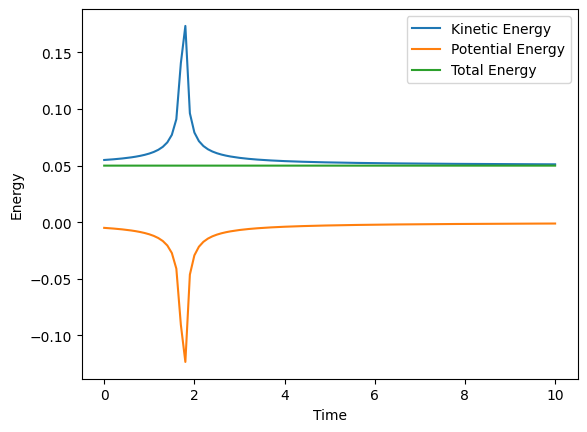

In [493]:
plt.figure()

plt.plot(t, KE, label='Kinetic Energy')
plt.plot(t, PE, label='Potential Energy')
plt.plot(t, KE + PE, label='Total Energy')

plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()

plt.show()

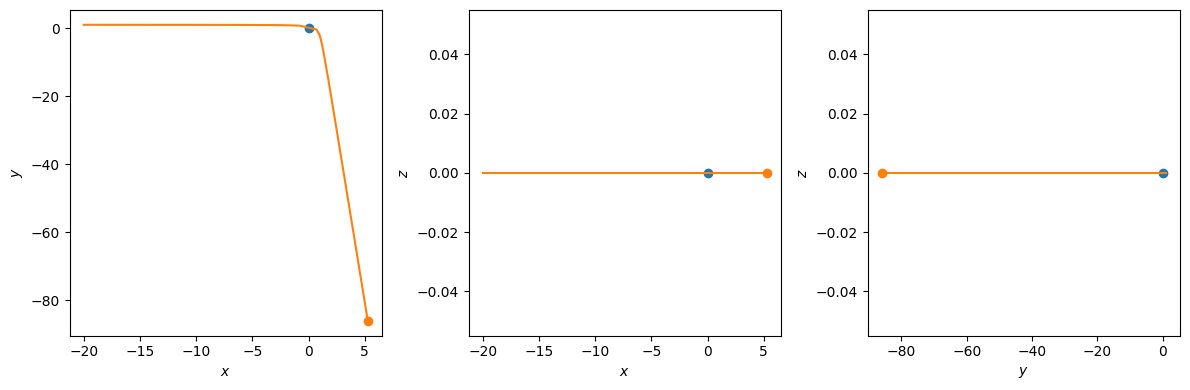

In [494]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))

for j in range(len(mass)):
    axs[0].plot(pos[:, j, 0], pos[:, j, 1],)
    axs[0].scatter(pos[-1, j, 0], pos[-1, j, 1], marker='o', )

    axs[1].plot(pos[:, j, 0], pos[:, j, 2], )
    axs[1].scatter(pos[-1, j, 0], pos[-1, j, 2], marker='o', )
    
    axs[2].plot(pos[:, j, 1], pos[:, j, 2], )
    axs[2].scatter(pos[-1, j, 1], pos[-1, j, 2], marker='o', )


axs[0].set_xlabel(r'$x$');
axs[0].set_ylabel(r'$y$')

axs[1].set_xlabel(r'$x$');
axs[1].set_ylabel(r'$z$')

axs[2].set_xlabel(r'$y$');
axs[2].set_ylabel(r'$z$')

fig.tight_layout()

plt.show()

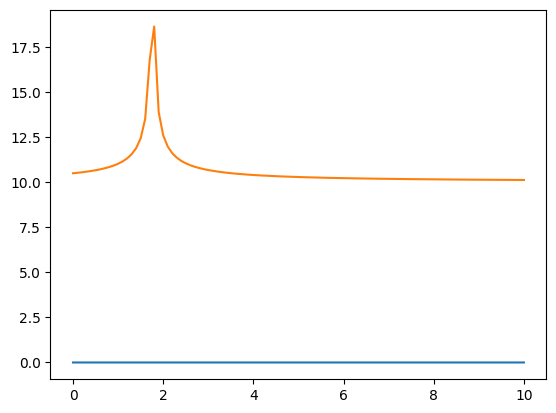

In [495]:
vel_mag = np.linalg.norm(vel, axis=-1)

plt.figure()
for i in range(len(mass)):
    plt.plot(t, vel_mag[:, i], label=f'Particle {i}')

plt.show()